# Experiment One
All available training data

## Augmentation of dataset

In [4]:
EXP_NUM=1

In [5]:
import tensorflow as tf
from pathlib import Path


def augment_in_place_orig_plus_4_no_resize(
    root: str | Path,
    *,
    allowed_ext: tuple[str, ...] = (".jpg", ".jpeg", ".png", ".webp", ".bmp", ".tif", ".tiff"),
    jpeg_quality: int = 95,
    suffix_sep: str = "__",
) -> dict[str, int]:
    """
    Dla każdego obrazu w root/<class_name>/:
      - NIE zmienia wymiarów obrazu
      - NIE usuwa oryginału
      - dodaje 4 nowe obrazy w tym samym folderze:
        flip, rot90, bright, contrast

    Zwraca: dict {class_name: liczba_dodanych_obrazów}
    """
    root = Path(root)
    allowed = {e.lower() for e in allowed_ext}
    stats: dict[str, int] = {}

    def load_image(path: Path) -> tf.Tensor:
        b = tf.io.read_file(str(path))
        # decode_image zachowuje oryginalny rozmiar
        img = tf.image.decode_image(b, channels=3, expand_animations=False)
        img = tf.cast(tf.clip_by_value(img, 0, 255), tf.uint8)
        return img

    def save_jpeg(img_uint8: tf.Tensor, out_path: Path):
        jpeg = tf.io.encode_jpeg(img_uint8, quality=jpeg_quality)
        tf.io.write_file(str(out_path), jpeg)

    # 4 augmentacje zachowujące rozmiar
    def aug_flip(img):      return tf.image.flip_left_right(img)
    def aug_rot90(img):     return tf.image.rot90(img, k=1)   # 90°
    def aug_bright(img):
        x = tf.image.adjust_brightness(tf.cast(img, tf.float32), 0.15 * 255.0)
        return tf.cast(tf.clip_by_value(x, 0, 255), tf.uint8)
    def aug_contrast(img):
        x = tf.image.adjust_contrast(tf.cast(img, tf.float32), 1.2)
        return tf.cast(tf.clip_by_value(x, 0, 255), tf.uint8)

    variants = [
        ("flip", aug_flip),
        ("rot90", aug_rot90),
        ("bright", aug_bright),
        ("contrast", aug_contrast),
    ]

    for class_dir in [p for p in root.iterdir() if p.is_dir()]:
        class_name = class_dir.name

        originals = [
            p for p in class_dir.iterdir()
            if p.is_file()
            and p.suffix.lower() in allowed
            and suffix_sep not in p.stem
        ]

        added = 0
        for p in originals:
            img = load_image(p)

            for tag, fn in variants:
                out_path = class_dir / f"{p.stem}{suffix_sep}{tag}.jpg"
                if out_path.exists():
                    continue
                save_jpeg(fn(img), out_path)
                added += 1

        stats[class_name] = added

    return stats


In [6]:
stats = augment_in_place_orig_plus_4_no_resize(
    root=f"data/E{EXP_NUM}/train",
)

print(stats)


{'black_morel': 160, 'bitter_bolete': 160, 'curry_milkcap': 160, 'destroying_angel': 160, 'brown_birch_bolete': 160}


## Importing datasets

In [7]:
import tensorflow as tf
from pathlib import Path
import os

TRAIN_DIR = f"data/E{EXP_NUM}/train"
TEST_DIR = "data/test"

IMG_SIZE = (512, 512)
BATCH_SIZE = 8
SEED = 42

# 4 augmentacje (takie same dla AlexNet i ResNet50)
AUG_SUFFIX_SEP = "__"
AUG_TAGS = ["flip", "rot90", "bright", "contrast"]

def _list_augmented_files(root: str | Path, tag: str, allowed_ext=(".jpg",".jpeg",".png",".webp",".bmp",".tif",".tiff")):
    root = Path(root)
    allowed = {e.lower() for e in allowed_ext}
    files, labels = [], []
    class_names = sorted([p.name for p in root.iterdir() if p.is_dir()])
    class_to_idx = {c:i for i,c in enumerate(class_names)}
    for c in class_names:
        class_dir = root / c
        for p in class_dir.iterdir():
            if not p.is_file():
                continue
            if p.suffix.lower() not in allowed:
                continue
            # tylko dane zaugmentowane daną augmentacją (bez oryginałów i bez innych augmentacji)
            if f"{AUG_SUFFIX_SEP}{tag}" not in p.stem:
                continue
            files.append(str(p))
            labels.append(class_to_idx[c])
    return files, labels, class_names

def _decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32)
    return img, label

def make_train_ds_for_aug(tag: str, shuffle=True):
    files, labels, class_names = _list_augmented_files(TRAIN_DIR, tag)
    if len(files) == 0:
        raise ValueError(f"Brak plików treningowych dla augmentacji '{tag}'. Upewnij się, że augmentacje zostały wygenerowane w {TRAIN_DIR}.")
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 2048), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds, class_names

# Test (bez augmentacji)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="int"
).prefetch(tf.data.AUTOTUNE)

print("Ustawienia:")
print(" IMG_SIZE   =", IMG_SIZE)
print(" BATCH_SIZE =", BATCH_SIZE)
print(" AUG_TAGS   =", AUG_TAGS)


Found 20 files belonging to 5 classes.
Ustawienia:
 IMG_SIZE   = (512, 512)
 BATCH_SIZE = 8
 AUG_TAGS   = ['flip', 'rot90', 'bright', 'contrast']


## AlexNet512

In [8]:
import tensorflow as tf

def lrn(x, depth_radius=2, bias=1.0, alpha=1e-4, beta=0.75):
    return tf.nn.local_response_normalization(
        x, depth_radius=depth_radius, bias=bias, alpha=alpha, beta=beta
    )

def build_alexnet_512(input_shape=(512, 512, 3), num_classes=5, dropout=0.2):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    # Conv1
    x = tf.keras.layers.Conv2D(96, 11, strides=4, padding="valid", activation="relu")(x)
    x = tf.keras.layers.Lambda(lrn)(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2)(x)

    # Conv2
    x = tf.keras.layers.Conv2D(256, 5, padding="same", activation="relu")(x)
    x = tf.keras.layers.Lambda(lrn)(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2)(x)

    # Conv3-5
    x = tf.keras.layers.Conv2D(384, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(384, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2)(x)

    # Zamiast Flatten (żeby 512x512 nie zabiło parametrów)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # FC (AlexNet-like)
    x = tf.keras.layers.Dense(4096, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(4096, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs, name="alexnet_512")


## Residual Network (ResNet50)

In [9]:
import tensorflow as tf

def build_resnet50_512(num_classes: int, input_shape=(512, 512, 3), train_base: bool = False):
    inputs = tf.keras.Input(shape=input_shape)

    # ResNet50 oczekuje preprocess_input
    x = tf.keras.applications.resnet50.preprocess_input(inputs)

    base = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        pooling=None
    )
    base.trainable = train_base  # False = zamrożony backbone

    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="resnet50_512")
    return model




## Trening 8 modeli (AlexNet i ResNet50 × 4 augmentacje)

- Uczymy łącznie **8 modeli**: 4×AlexNet512 i 4×ResNet50.
- Dla obu architektur używamy **tych samych 4 augmentacji**: `flip`, `rot90`, `bright`, `contrast`.
- **Modele uczą się wyłącznie na danych zaugmentowanych** (oryginały są pomijane w `train_ds`).
- Zbiór testowy pozostaje bez augmentacji.



=== Trenowanie: alexnet | augmentacja: flip | klasy: 5 ===
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 1.6131 - sparse_categorical_accuracy: 0.1504
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1909
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 1.6111 - sparse_categorical_accuracy: 0.1477
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 1.6107 - sparse_categorical_accuracy: 0.2201
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 1.6102 - sparse_categorical_accuracy: 0.1743
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 1.6009 - sparse_categorical_accuracy: 0.2920
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 1.6018 - sparse_categorical_accuracy: 0.2608
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 1.5947 - sparse_categorical_accuracy: 0.2618
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 1.6059 - sparse_categorical_accuracy: 0

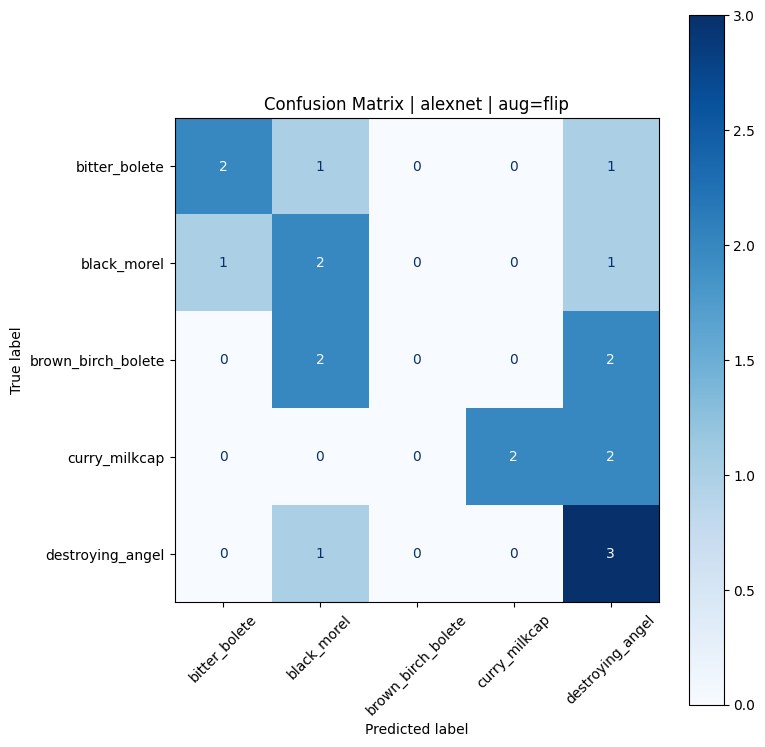


=== Trenowanie: alexnet | augmentacja: rot90 | klasy: 5 ===
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 1.6124 - sparse_categorical_accuracy: 0.1431
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.6099 - sparse_categorical_accuracy: 0.1735
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 1.6101 - sparse_categorical_accuracy: 0.1580
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.6096 - sparse_categorical_accuracy: 0.2351
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 1.6090 - sparse_categorical_accuracy: 0.2224
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 1.6043 - sparse_categorical_accuracy: 0.2446
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.5975 - sparse_categorical_accuracy: 0.2595
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.5975 - sparse_categorical_accuracy: 0.2416
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.6253 - sparse_categorical_accuracy: 0

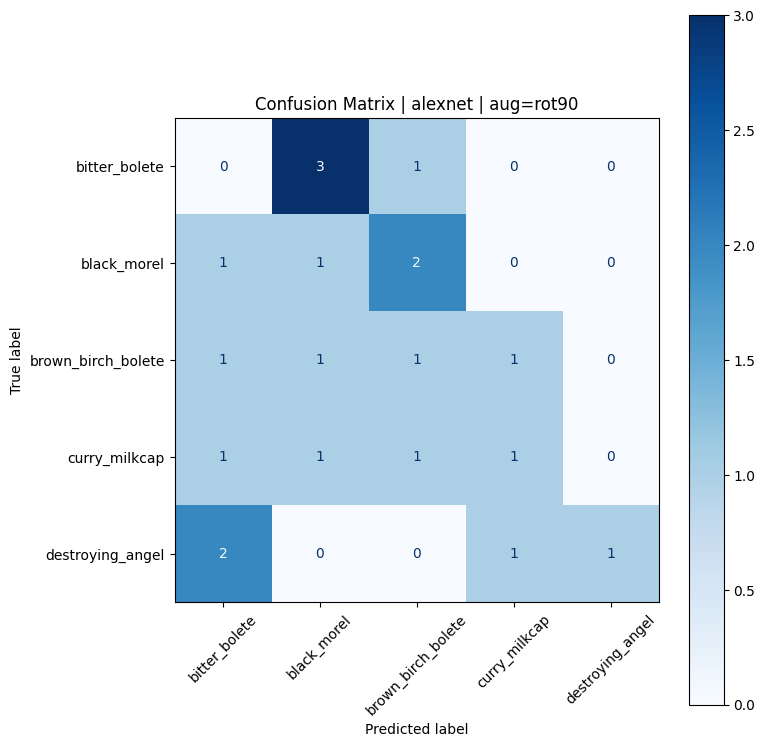


=== Trenowanie: alexnet | augmentacja: bright | klasy: 5 ===
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 1.6139 - sparse_categorical_accuracy: 0.1665
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 1.6109 - sparse_categorical_accuracy: 0.2217
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.6116 - sparse_categorical_accuracy: 0.1480
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 1.6128 - sparse_categorical_accuracy: 0.1874
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 1.6125 - sparse_categorical_accuracy: 0.1378
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.6100 - sparse_categorical_accuracy: 0.2038
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.6112 - sparse_categorical_accuracy: 0.1986
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 1.6101 - sparse_categorical_accuracy: 0.2338
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 1.6145 - sparse_categorical_accuracy: 

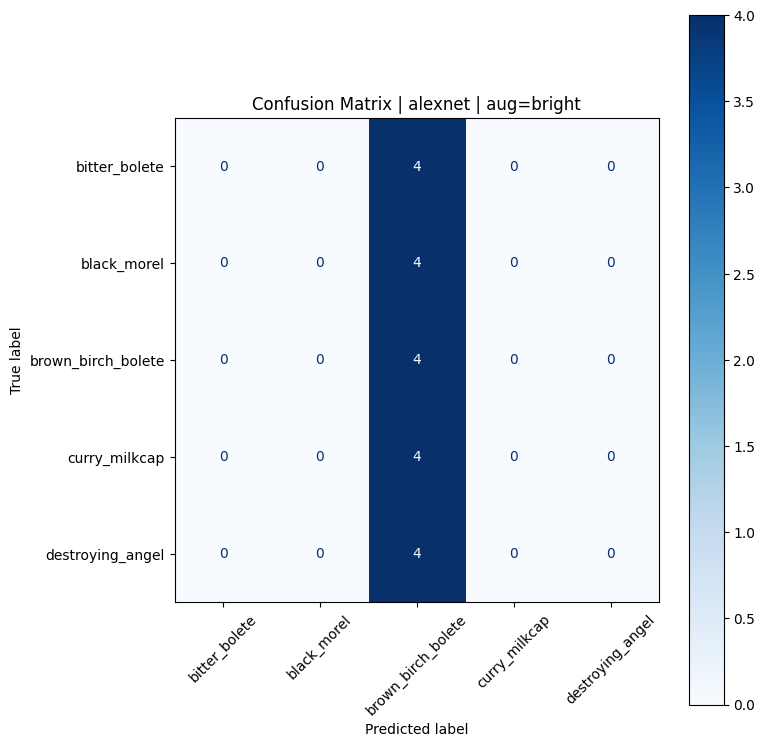


=== Trenowanie: alexnet | augmentacja: contrast | klasy: 5 ===
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 1.6127 - sparse_categorical_accuracy: 0.1597
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 1.6093 - sparse_categorical_accuracy: 0.1909
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 1.6107 - sparse_categorical_accuracy: 0.1628
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.6093 - sparse_categorical_accuracy: 0.2139
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.6057 - sparse_categorical_accuracy: 0.1798
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.5982 - sparse_categorical_accuracy: 0.2520
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 1.5755 - sparse_categorical_accuracy: 0.3390
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 1.6235 - sparse_categorical_accuracy: 0.1472
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 1.6118 - sparse_categorical_accuracy

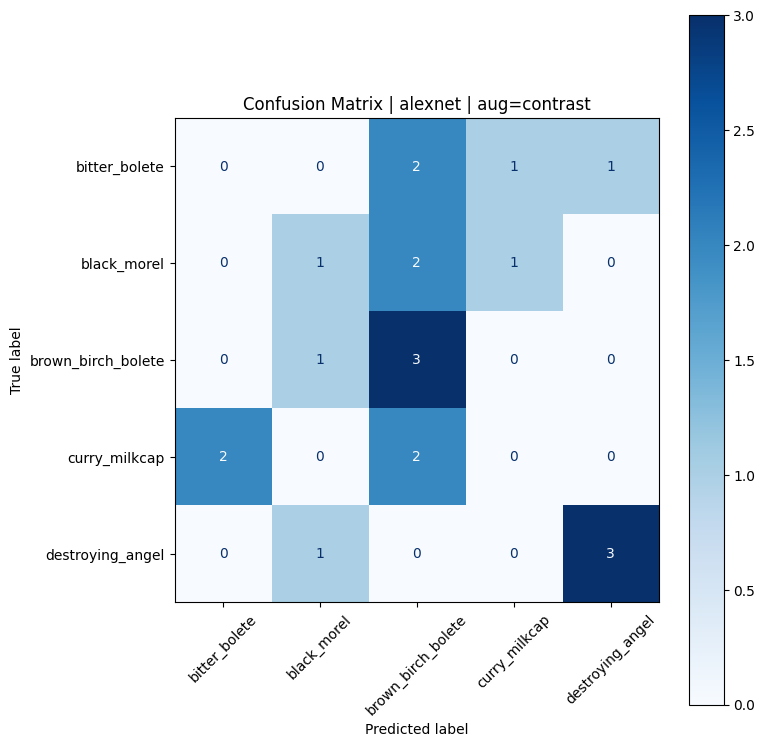

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

=== Trenowanie: resnet50 | augmentacja: flip | klasy: 5 ===
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 1.8169 - sparse_categorical_accuracy: 0.2634
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.8545 - sparse_categorical_accuracy: 0.7451
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.5240 - sparse_categorical_accuracy: 0.8404
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.3860 - sparse_categorical_accuracy: 0.9206
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.3273 - sparse_categorical_accuracy: 0.9005
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.2325 - sparse_categorical_accuracy: 0.9455
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.2278 - sparse_categorical_accuracy: 0.9429
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.2373 - sparse_categorical_accuracy: 0.9760
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/ste

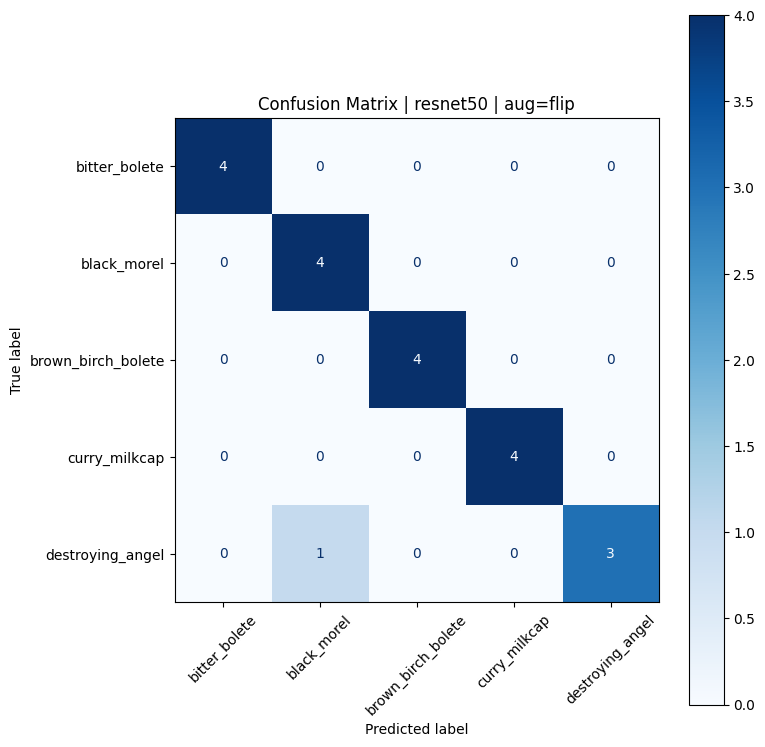


=== Trenowanie: resnet50 | augmentacja: rot90 | klasy: 5 ===
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 1.8693 - sparse_categorical_accuracy: 0.2789
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.9673 - sparse_categorical_accuracy: 0.6739
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.5915 - sparse_categorical_accuracy: 0.7992
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.4424 - sparse_categorical_accuracy: 0.8396
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.3504 - sparse_categorical_accuracy: 0.9253
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.3011 - sparse_categorical_accuracy: 0.9219
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.2583 - sparse_categorical_accuracy: 0.9542
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.2282 - sparse_categorical_accuracy: 0.9752
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.2133 - sparse_categorical_accuracy: 0.9

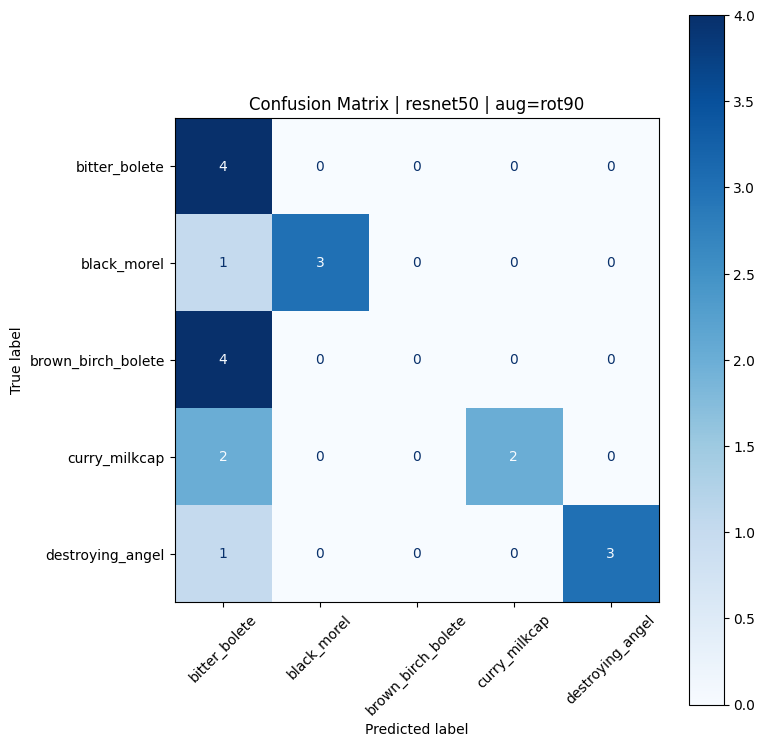


=== Trenowanie: resnet50 | augmentacja: bright | klasy: 5 ===
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 1.7711 - sparse_categorical_accuracy: 0.3071
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 1.0067 - sparse_categorical_accuracy: 0.6266
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.5315 - sparse_categorical_accuracy: 0.8480
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.3974 - sparse_categorical_accuracy: 0.8972
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.3341 - sparse_categorical_accuracy: 0.9018
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.2452 - sparse_categorical_accuracy: 0.9591
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.2325 - sparse_categorical_accuracy: 0.9493
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.1989 - sparse_categorical_accuracy: 0.9540
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.1844 - sparse_categorical_accuracy: 

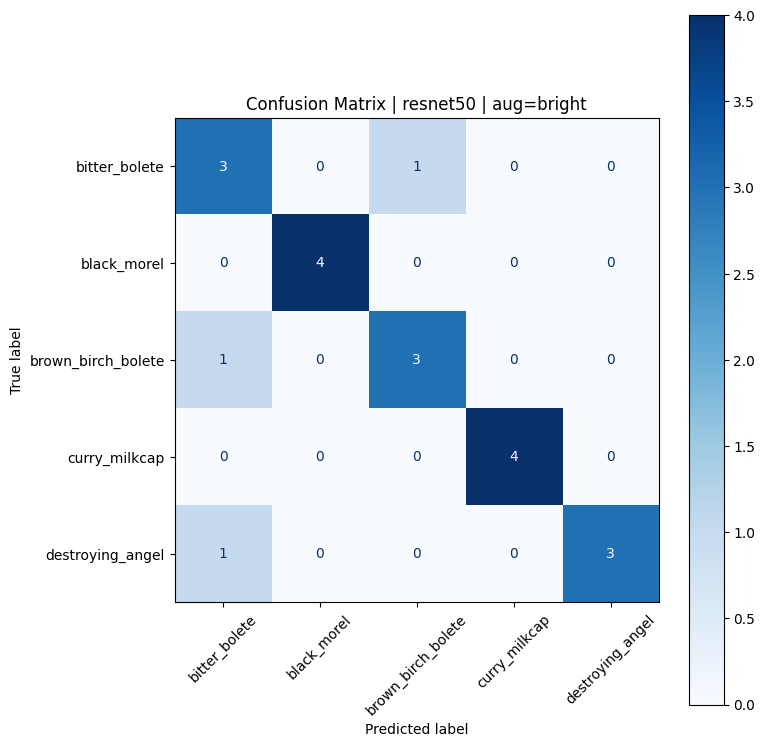


=== Trenowanie: resnet50 | augmentacja: contrast | klasy: 5 ===
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 1.7787 - sparse_categorical_accuracy: 0.2727
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.8957 - sparse_categorical_accuracy: 0.6953
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.5438 - sparse_categorical_accuracy: 0.8384
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.3795 - sparse_categorical_accuracy: 0.8829
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.3564 - sparse_categorical_accuracy: 0.8974
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.2597 - sparse_categorical_accuracy: 0.9423
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.2139 - sparse_categorical_accuracy: 0.9682
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.2087 - sparse_categorical_accuracy: 0.9556
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.1572 - sparse_categorical_accurac

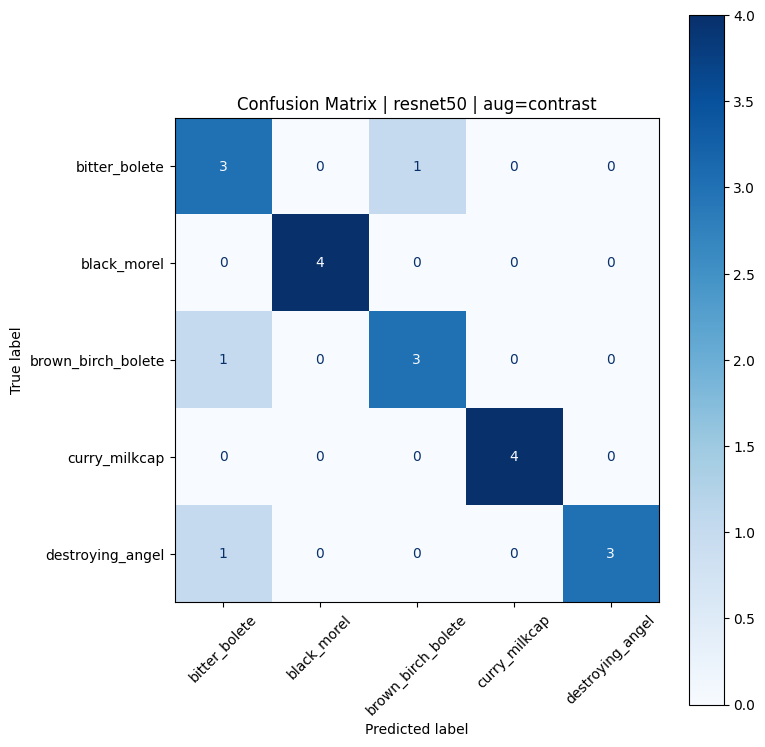

,model,augmentation,epochs,test_acc,test_loss,weights_path
2,alexnet,bright,100,0.20,1.609564,models/e1_alexnet_bright.weights.h5
3,alexnet,contrast,100,0.35,1.503827,models/e1_alexnet_contrast.weights.h5
0,alexnet,flip,100,0.45,1.619854,models/e1_alexnet_flip.weights.h5
1,alexnet,rot90,100,0.20,1.663093,models/e1_alexnet_rot90.weights.h5
6,resnet50,bright,10,0.85,0.480881,models/e1_resnet50_bright.weights.h5
7,resnet50,contrast,10,0.85,0.505002,models/e1_resnet50_contrast.weights.h5
4,resnet50,flip,10,0.95,0.503286,models/e1_resnet50_flip.weights.h5
5,resnet50,rot90,10,0.60,0.741821,models/e1_resnet50_rot90.weights.h5


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

Path("models").mkdir(parents=True, exist_ok=True)

def train_and_evaluate(model_name: str, aug_tag: str):
    train_ds, class_names = make_train_ds_for_aug(aug_tag, shuffle=True)
    num_classes = len(class_names)

    if model_name == "alexnet":
        model = build_alexnet_512(input_shape=(*IMG_SIZE, 3), num_classes=num_classes, dropout=0.2)
        model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        )
        epochs = 100
    elif model_name == "resnet50":
        model = build_resnet50_512(num_classes=num_classes, input_shape=(*IMG_SIZE, 3), train_base=False)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        )
        epochs = 10
    else:
        raise ValueError("Nieznany model_name")

    print(f"\n=== Trenowanie: {model_name} | augmentacja: {aug_tag} | klasy: {num_classes} ===")
    history = model.fit(train_ds, epochs=epochs, verbose=1)

    weights_path = f"models/e{EXP_NUM}_{model_name}_{aug_tag}.weights.h5"
    model.save_weights(weights_path)
    print("Zapisano wagi:", weights_path)

    test_loss, test_acc = model.evaluate(test_ds, verbose=1)

    # predykcje + macierz pomyłek
    y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
    y_pred = np.argmax(model.predict(test_ds, verbose=0), axis=1)
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=45)
    plt.title(f"Confusion Matrix | {model_name} | aug={aug_tag}")
    plt.tight_layout()
    plt.show()

    return {
        "model": model_name,
        "augmentation": aug_tag,
        "epochs": epochs,
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "weights_path": weights_path,
        "history": history.history,
        "class_names": class_names,
        "confusion_matrix": cm,
    }

results = []
for aug_tag in AUG_TAGS:
    # 4 modele AlexNet (po 1 na augmentację)
    results.append(train_and_evaluate("alexnet", aug_tag))

for aug_tag in AUG_TAGS:
    # 4 modele ResNet50 (po 1 na augmentację)
    results.append(train_and_evaluate("resnet50", aug_tag))

# Podsumowanie
import pandas as pd
summary = pd.DataFrame([{
    "model": r["model"],
    "augmentation": r["augmentation"],
    "epochs": r["epochs"],
    "test_acc": r["test_acc"],
    "test_loss": r["test_loss"],
    "weights_path": r["weights_path"],
} for r in results]).sort_values(["model", "augmentation"])

summary
